In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib.ticker
from collections import defaultdict

plt.style.use(["science", "no-latex", "grid"])

result_dir = "../../output/low_dim/dino"

In [2]:
fn = f"{result_dir}/steps_5/results.pt"
data = torch.load(fn)
results = data["results"]

target = data["target"]
delta_points = target["points"]
delta_weights = target["weights"]

meta = data["meta"]
n_steps = meta["n_steps"]
n_samples = meta["n_samples"]

print(
    f"number of points: {len(delta_points)}",
    f"number of samples: {n_samples}",
    f"number of steps: {n_steps}",
    sep="\n",
)

number of points: 142
number of samples: 1000
number of steps: 5


In [3]:
methods = results.keys()

In [4]:
method2title = {
    "score, canonical Euler Maruyama": "Score\nStandard Euler",
    "score, denoise, eps=0.001": "Score\nDenoising, eps=1e-3",
    "score, denoise, eps=1e-05": "Score\nDenoising, eps=1e-5",
    "prox, hybrid": "PDA-Hybrid (Ours)",
    "prox, full": "PDA (Ours)",
}

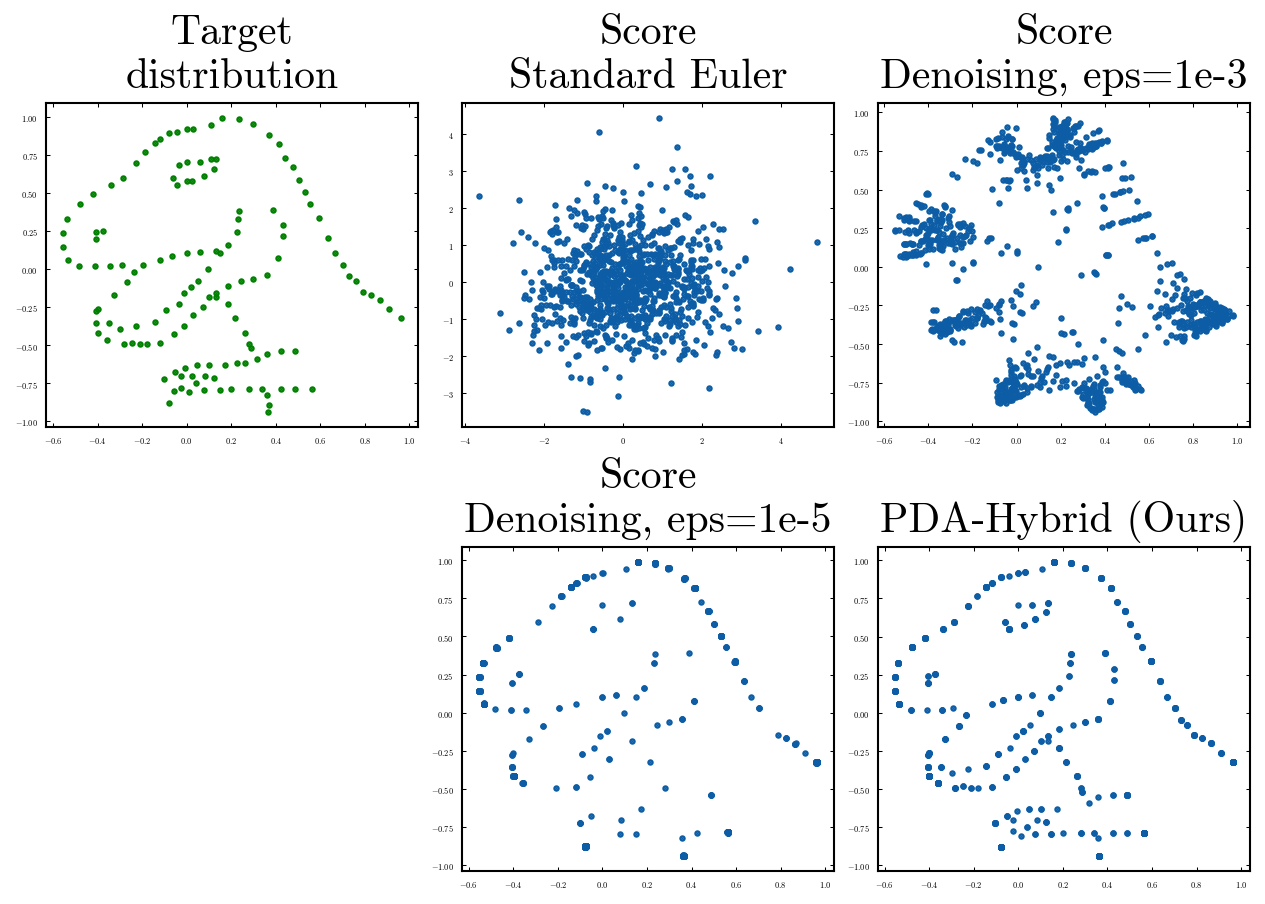

In [5]:
# plot final samples
title_kwargs = {"fontsize": 10, "pad": 4}
nc = 3
nr = 2
fig, axes = plt.subplots(nr, nc, figsize=(4.2, 3), dpi=300)
ax = axes[0, 0]
ax.scatter(delta_points[:, 0], delta_points[:, 1], s=0.3, c="g")
ax.set_title("Target\ndistribution", **title_kwargs)

for (i, j), method in zip([(0, 1), (0, 2), (1, 1), (1, 2)], methods):
    samples = results[method]["trajectory"][-1]
    ax = axes[i, j]
    ax.scatter(samples[:, 0], samples[:, 1], s=0.3)
    n_nonnans = (~(torch.isnan(samples).any(dim=1))).sum().item()
    if n_nonnans != len(samples):
        raise ValueError("NaN values in samples")
    ax.set_title(method2title[method], **title_kwargs)


for ax in axes.flatten():
    ax.tick_params(labelsize=2, length=1, width=0.25, pad=2)
    ax.minorticks_off()
    ax.grid(False)  # Turn off grid

axes[1, 0].axis("off")

fig.tight_layout(pad=0.3)
fig.savefig("toy.svg", bbox_inches="tight")

In [6]:
# Plot distance by nfe
wass_p = 2

n_steps_list = [5, 7, 10, 20, 30, 40]

dist_by_nfe = defaultdict(list)
for nfe in n_steps_list:
    fn = f"{result_dir}/steps_{nfe}/results.pt"
    data = torch.load(fn)
    results = data["results"]

    for method in [
        "score, canonical Euler Maruyama",
        "score, denoise, eps=0.001",
        "score, denoise, eps=1e-05",
        "prox, hybrid",
        "prox, full",
    ]:
        if method in results:
            r = results[method]
            dist_by_nfe[method].append(r["w_dist"][f"w{wass_p}"][-1])
        else:
            dist_by_nfe[method].append(None)

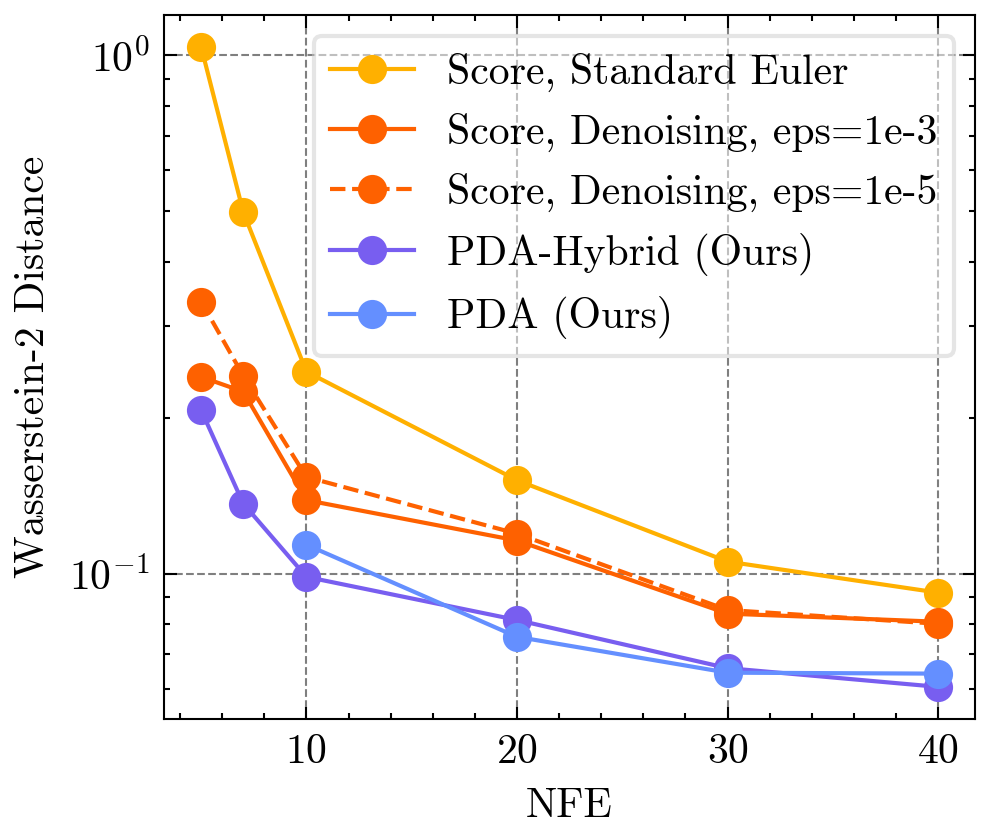

In [7]:
plot_kwargs = {
    "score, canonical Euler Maruyama": {
        "color": "#ffb000",
    },
    "score, denoise, eps=0.001": {
        "color": "#fe6100",
    },
    "score, denoise, eps=1e-05": {
        "color": "#fe6100",
        "linestyle": "--",
    },
    "prox, hybrid": {
        "color": "#785ef0",
    },
    "prox, full": {"color": "#648fff"},
    "default": {
        "marker": "o",
    },
}

fig, ax = plt.subplots(figsize=(3.5, 3), dpi=300)

for method, dist_list in dist_by_nfe.items():
    label = method2title[method].replace("\n", ", ")
    kwargs = plot_kwargs["default"].copy()
    kwargs.update(plot_kwargs[method])
    ax.plot(n_steps_list, dist_list, label=label, **kwargs)

ax.set_xlabel("NFE")
ax.set_ylabel(f"Wasserstein-{wass_p} Distance")
ax.set_yscale("log")
ax.legend(framealpha=0.5)
fig.tight_layout()
fig.savefig("toy_wdist_nfe.svg", bbox_inches="tight")